# ENCM 509 Project - User Recognition Using Leap Motion and SVM


* Team member - Abid Al Labib 
    - UCID: 30070079
* Team member - Madhu Selvaraj
    - UCID: 30061979
    

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath
import warnings
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from utils_cm import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Setup

In [31]:
# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 100
# the number of features (from the data)
NUMBER_FEATURES = 202
# the number of classes/gestures
NUMBER_OUTPUTS = 2
# you can encode more than 1 but for this example we have binary output (circle/swipe)

In [32]:
# the directory where your data is
mypath = './data_recollected'

# creating a list with all the filenames
datafiles = [f for f in listdir('data') if isfile(join(mypath, f))]

In [33]:
# choose data we need
columns = ['handPalmPosition_X','handPalmPosition_Y','handPalmPosition_Z',
          'pitch', 'roll', 'yaw',
          'wristPosition_X', 'wristPosition_Y','wristPosition_Z',
          'elbowPosition_X', 'elbowPosition_Y', 'elbowPosition_Z']

finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
bone_names = ['Metacarpal', 'Proximal', 'Intermediate', 'Distal']
    
for finger in finger_names:
    columns.append(finger + 'Length')
    columns.append(finger + 'Width')

for finger in finger_names:
    for bone in bone_names:
        columns.append(finger + bone + 'Start_X')
        columns.append(finger + bone + 'Start_Y')
        columns.append(finger + bone + 'Start_Z')
        columns.append(finger + bone + 'End_X')
        columns.append(finger + bone + 'End_Y')
        columns.append(finger + bone + 'End_Z')
        columns.append(finger + bone + 'Direction_X') 
        columns.append(finger + bone + 'Direction_Y') 
        columns.append(finger + bone + 'Direction_Z')   

In [41]:
# Features
x = []
# Labels
y = []

class1 = []
class2 = []
for sample in datafiles:
    relative_path = 'data/' + sample
    tmp = pd.read_csv(relative_path, usecols=columns)
    
    # Normalize the sample size
    print('{}\nsize raw = {}'.format(relative_path,tmp.shape))
    while tmp.shape[0] < NUMBER_TIMESTEPS:
        tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)

    if tmp.shape[0] > NUMBER_TIMESTEPS:
        tmp = tmp.head(100)
    print('size normalized = ',tmp.shape)
    
    tmp_x = tmp[[column for column in list(tmp.columns)]]

    tmp_y = [1,  0]
    if '2c' in sample or '2s' in sample:
        tmp_y = [0, 1]
        class2.append(tmp_x)
    else:
        class1.append(tmp_x)  
        
    x.append(tmp_x)
    y.append(tmp_y)

data/1c1.csv
size raw = (28, 202)
size normalized =  (100, 202)
data/1c10.csv
size raw = (23, 202)
size normalized =  (100, 202)
data/1c2.csv
size raw = (15, 202)
size normalized =  (100, 202)
data/1c3.csv
size raw = (13, 202)
size normalized =  (100, 202)
data/1c4.csv
size raw = (18, 202)
size normalized =  (100, 202)
data/1c5.csv
size raw = (25, 202)
size normalized =  (100, 202)
data/1c6.csv
size raw = (18, 202)
size normalized =  (100, 202)
data/1c7.csv
size raw = (24, 202)
size normalized =  (100, 202)
data/1c8.csv
size raw = (19, 202)
size normalized =  (100, 202)
data/1c9.csv
size raw = (48, 202)
size normalized =  (100, 202)
data/1s1.csv
size raw = (33, 202)
size normalized =  (100, 202)
data/1s10.csv
size raw = (24, 202)
size normalized =  (100, 202)
data/1s2.csv
size raw = (20, 202)
size normalized =  (100, 202)
data/1s3.csv
size raw = (22, 202)
size normalized =  (100, 202)
data/1s4.csv
size raw = (21, 202)
size normalized =  (100, 202)
data/1s5.csv
size raw = (18, 202)
size

In [35]:
# Each sample requires labels of [1,NUMBER_OUTPUTS] size (not a list)
y_new = list()
for cur_label in y:
    tmp = np.array(cur_label[0])
    y_new.append(tmp)
y = np.array(y_new)
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


### Comparsion of pitch, roll, and yaw for the two classes (for a single swipe gesture)

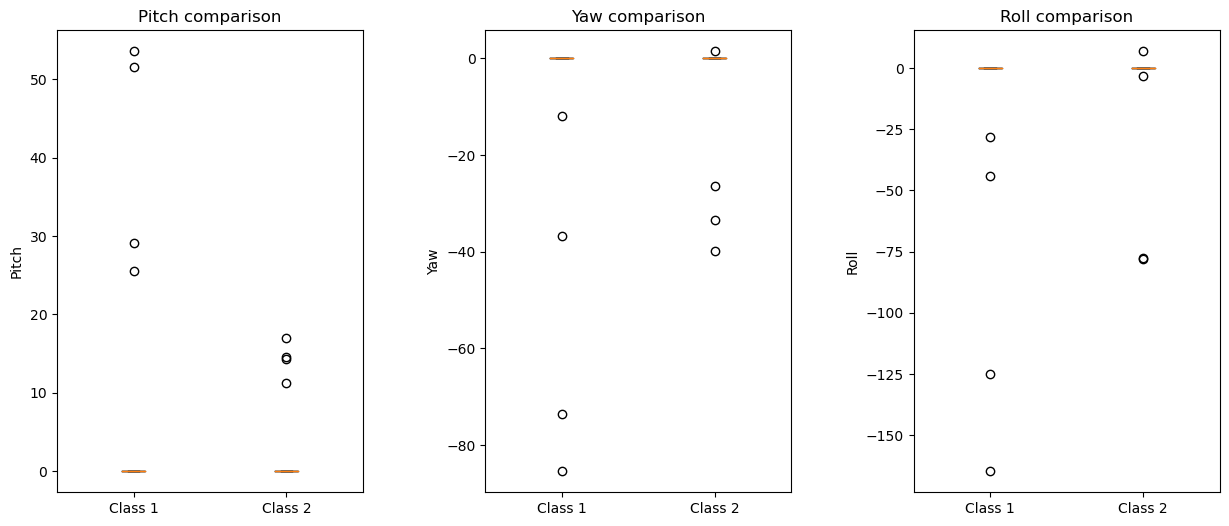

In [36]:
df1 = class1[18]
df2 = class2[18]

#pitch
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].boxplot([df1['pitch'], df2['pitch']])
axs[0].set_xticklabels(['Class 1', 'Class 2'])
axs[0].set_ylabel('Pitch')
axs[0].set_title('Pitch comparison')

#yaw
axs[1].boxplot([df1['yaw'], df2['yaw']])
axs[1].set_xticklabels(['Class 1', 'Class 2'])
axs[1].set_ylabel('Yaw')
axs[1].set_title('Yaw comparison')

#roll
axs[2].boxplot([df1['roll'], df2['roll']])
axs[2].set_xticklabels(['Class 1', 'Class 2'])
axs[2].set_ylabel('Roll')
axs[2].set_title('Roll comparison')

plt.subplots_adjust(wspace=0.4)
plt.show()

## SVM Classification 

In [37]:
# Set a percentage of test set fraction
test_percent = 0.20 

# Divide data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_percent, shuffle=True, random_state=1)
len_train = len(X_train)
len_test = len(X_test)

print ('Number of train samples = {}\nNumber of test samples = {}'.format(len_train, len_test))

# Turn list(DataFrame) into numpy.ndarray with [len_train, NUMBER_TIMESTEPS, NUMBER_FEATURES]
X_train = np.array(X_train)
X_test = np.array(X_test)

Number of train samples = 32
Number of test samples = 8


In [38]:
#reshaping x train and x test into the correct dimensions
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))

### Using grid search + cross validation to determine the best hyperparameters and mean test scores

#### Also displaying confusion matrices for each hyperparameter combination

In [39]:
# Defining the hyperparameter grid
svc_params = {
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'C': [1, 10, 100],
    'gamma': [0.1, 0.01, 0.001],
}

# Perform grid search with cross-validation to find the best hyperparameters
svm = SVC()
grid_search = GridSearchCV(svm, param_grid=svc_params, cv=5)
grid_search.fit(d2_train_dataset, y_train)

# Printing the best hyperparameters and corresponding best score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}
Best score:  0.719047619047619


Params: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}, Mean test score: 0.657142857142857
Match rate: 1.00


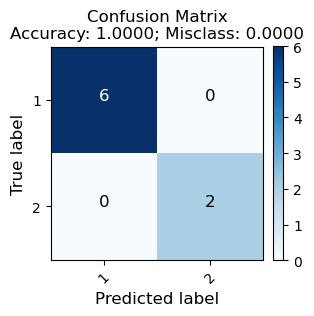

Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}, Mean test score: 0.5619047619047619
Match rate: 0.25


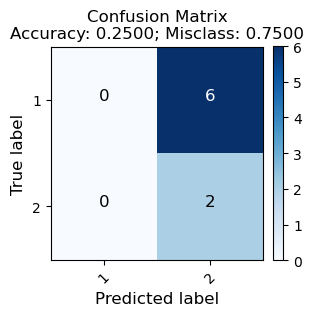

Params: {'C': 1, 'gamma': 0.1, 'kernel': 'sigmoid'}, Mean test score: 0.6857142857142857
Match rate: 0.25


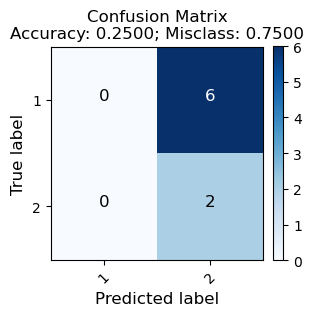

Params: {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}, Mean test score: 0.719047619047619
Match rate: 0.75


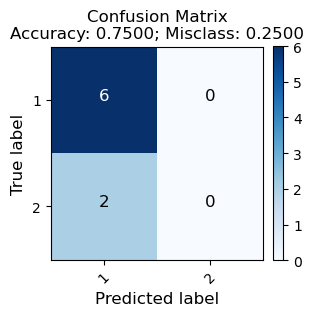

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}, Mean test score: 0.657142857142857
Match rate: 1.00


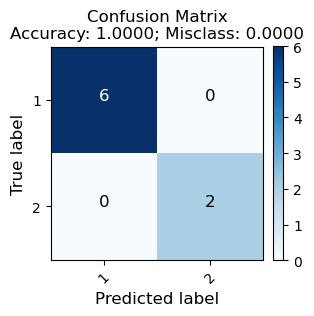

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}, Mean test score: 0.5619047619047619
Match rate: 0.25


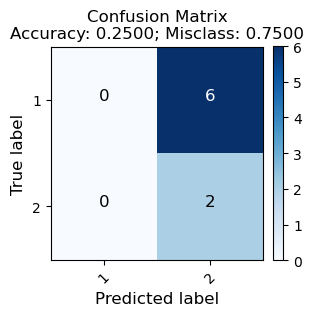

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}, Mean test score: 0.6857142857142857
Match rate: 0.25


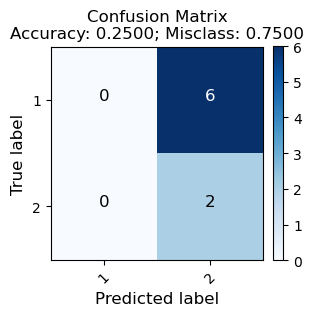

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}, Mean test score: 0.719047619047619
Match rate: 0.75


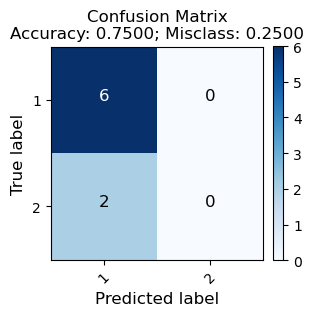

Params: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}, Mean test score: 0.657142857142857
Match rate: 1.00


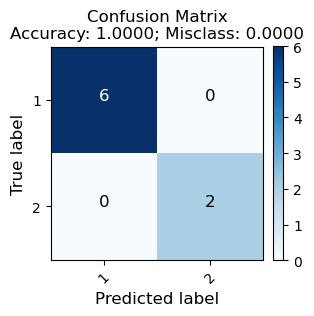

Params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}, Mean test score: 0.5619047619047619
Match rate: 0.25


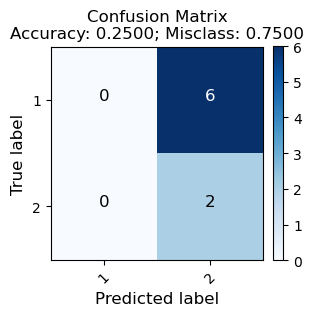

Params: {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}, Mean test score: 0.6857142857142857
Match rate: 0.25


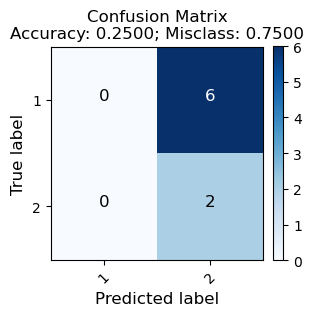

Params: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}, Mean test score: 0.719047619047619
Match rate: 0.75


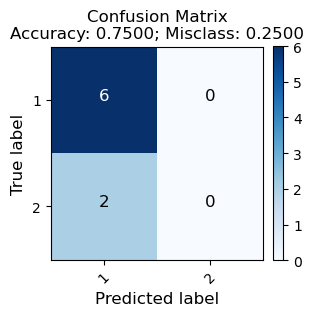

Params: {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}, Mean test score: 0.657142857142857
Match rate: 1.00


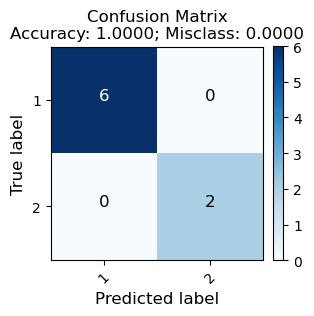

Params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, Mean test score: 0.5619047619047619
Match rate: 0.25


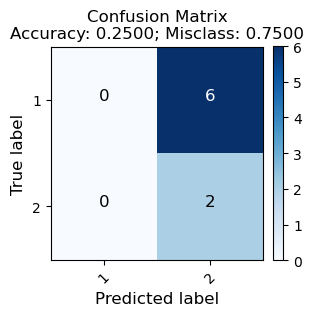

Params: {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}, Mean test score: 0.7142857142857143
Match rate: 0.25


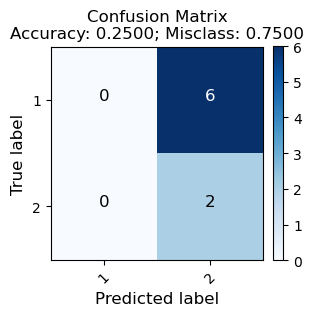

Params: {'C': 10, 'gamma': 0.1, 'kernel': 'poly'}, Mean test score: 0.719047619047619
Match rate: 0.75


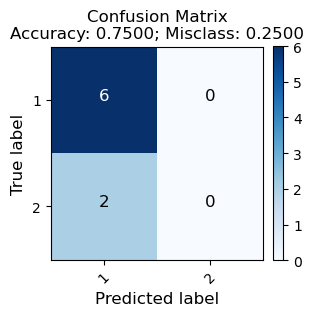

Params: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}, Mean test score: 0.657142857142857
Match rate: 1.00


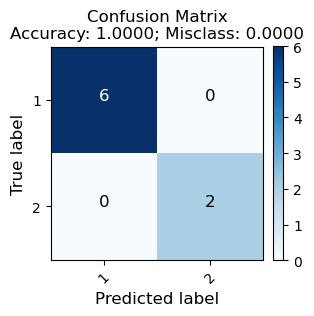

Params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}, Mean test score: 0.5619047619047619
Match rate: 0.25


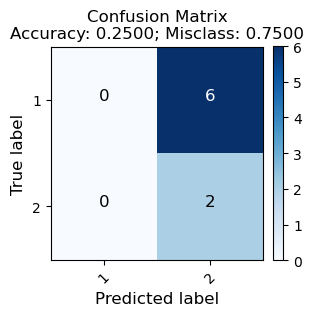

Params: {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}, Mean test score: 0.7142857142857143
Match rate: 0.25


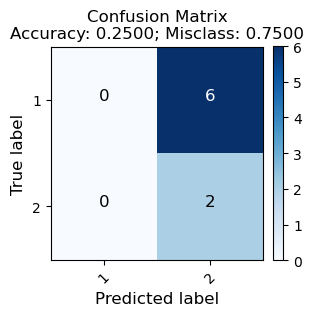

Params: {'C': 10, 'gamma': 0.01, 'kernel': 'poly'}, Mean test score: 0.719047619047619
Match rate: 0.75


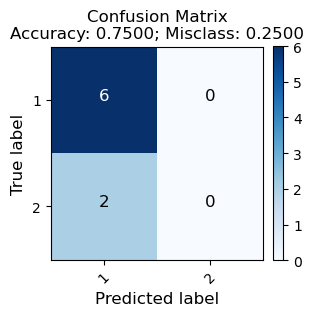

Params: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}, Mean test score: 0.657142857142857
Match rate: 1.00


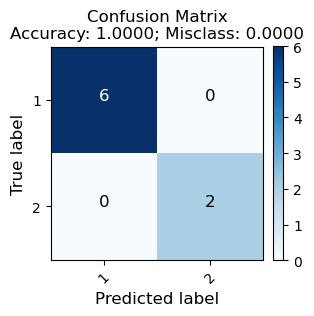

Params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, Mean test score: 0.5619047619047619
Match rate: 0.25


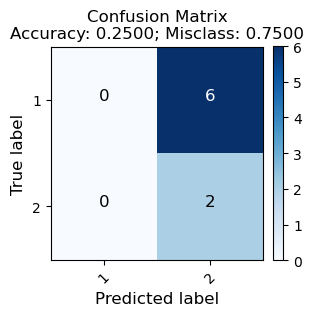

Params: {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}, Mean test score: 0.7142857142857143
Match rate: 0.25


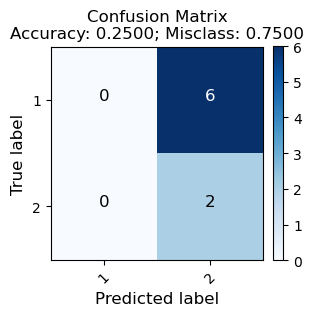

Params: {'C': 10, 'gamma': 0.001, 'kernel': 'poly'}, Mean test score: 0.719047619047619
Match rate: 0.75


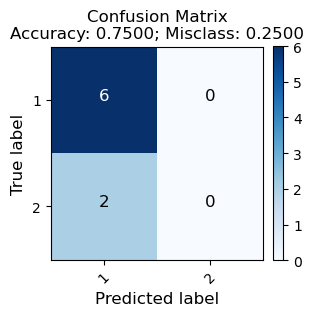

Params: {'C': 100, 'gamma': 0.1, 'kernel': 'linear'}, Mean test score: 0.657142857142857
Match rate: 1.00


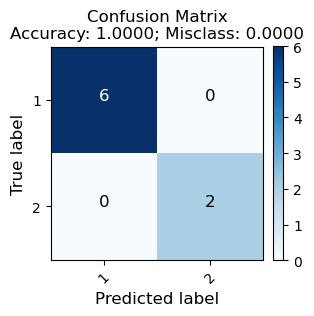

Params: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}, Mean test score: 0.5619047619047619
Match rate: 0.25


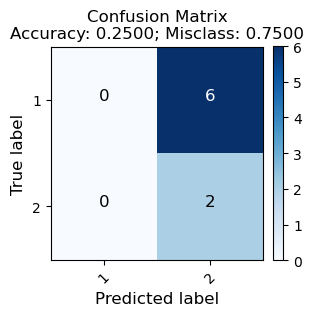

Params: {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}, Mean test score: 0.680952380952381
Match rate: 0.25


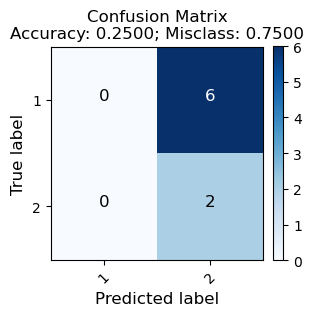

Params: {'C': 100, 'gamma': 0.1, 'kernel': 'poly'}, Mean test score: 0.719047619047619
Match rate: 0.75


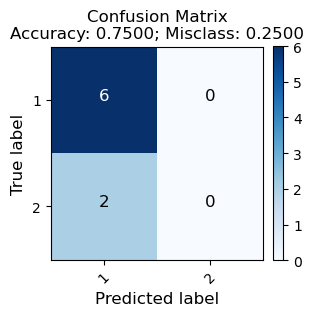

Params: {'C': 100, 'gamma': 0.01, 'kernel': 'linear'}, Mean test score: 0.657142857142857
Match rate: 1.00


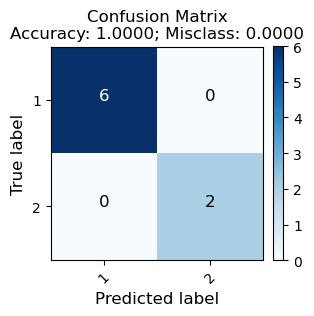

Params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}, Mean test score: 0.5619047619047619
Match rate: 0.25


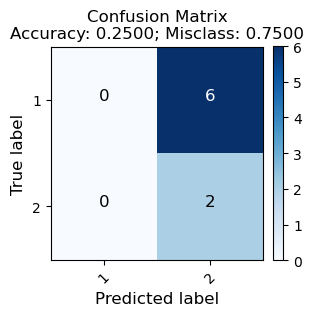

Params: {'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}, Mean test score: 0.680952380952381
Match rate: 0.25


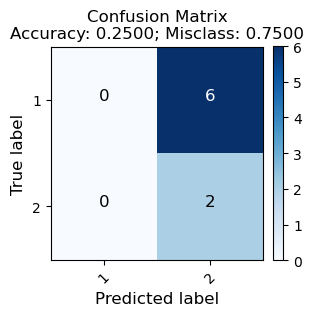

Params: {'C': 100, 'gamma': 0.01, 'kernel': 'poly'}, Mean test score: 0.719047619047619
Match rate: 0.75


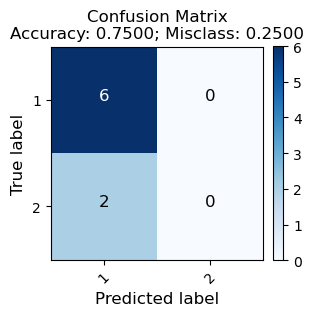

Params: {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}, Mean test score: 0.657142857142857
Match rate: 1.00


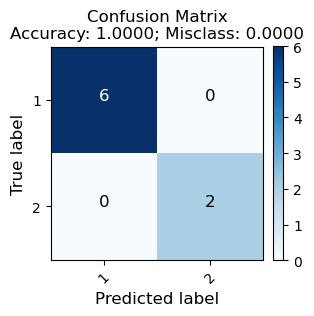

Params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}, Mean test score: 0.5619047619047619
Match rate: 0.25


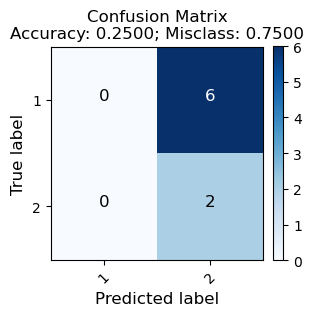

Params: {'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}, Mean test score: 0.680952380952381
Match rate: 0.25


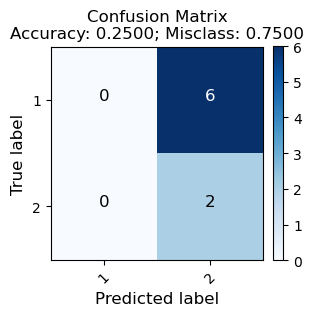

Params: {'C': 100, 'gamma': 0.001, 'kernel': 'poly'}, Mean test score: 0.719047619047619
Match rate: 0.75


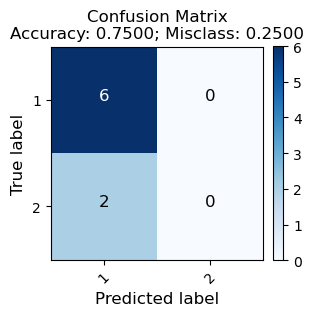

In [42]:
# Print the mean test score for each combination of hyperparameters, and also generate a confusion matrix for a single prediction
param_combos = grid_search.cv_results_['params']
mean_test_scores = grid_search.cv_results_['mean_test_score']
for params, mean_score in zip(param_combos, mean_test_scores):
    print(f"Params: {params}, Mean test score: {mean_score}")

    # Generate the confusion matrix
    clf = SVC(**params)
    clf.fit(d2_train_dataset, y_train)
    y_pred = clf.predict(d2_test_dataset)
    matches = (y_pred == y_test)
    match_rate = matches.sum() / float(len(matches))
    print('Match rate: %.2f' % (match_rate))
    confusionMatrix = confusion_matrix(y_test, y_pred)
    p = plot_confusion_matrix(cm=confusionMatrix,target_names = [i for i in range(1, 3)])
    p.show()